<h1 align="center">Facial Recognition Demo</h1>

    David Morley
    
    November 27, 2018

#### This code uses the Singular Value Decomposition of image arrays to reduce the complexity of the images. Then it uses the Euclidean norm to find the most similar images. Sample output is displayed throughout.

In [1]:
import os
import numpy as np
from imageio import imread
from matplotlib import pyplot as plt
from scipy import linalg as la

### Helper Functions

In [2]:
def get_faces(path="./faces94"):
    """Traverse the specified directory to obtain one image per subdirectory. 
    Flatten and convert each image to grayscale.
    
    Parameters:
        path (str): The directory containing the dataset of images.  
    
    Returns:
        ((mn,k) ndarray) An array containing one column vector per
            subdirectory. k is the number of people, and each original
            image is mxn.
    """
    # Traverse the directory and get one image per subdirectory.
    faces = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                # Load the image, convert it to grayscale,
                # and flatten it into a vector.
                faces.append(np.ravel(imread(dirpath+"/"+fname, as_gray=True)))
                break
    # Put all the face vectors column-wise into a matrix.
    return np.transpose(faces)

def sample_faces(k, path="./faces94"):
    """Generate k sample images from the given path.

    Parameters:
        n (int): The number of sample images to obtain. 
        path(str): The directory containing the dataset of images.  
    
    Yields:
        ((mn,) ndarray): An flattend mn-array representing a single
        image. k images are yielded in total.
    """
    files = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        for fname in filenames:
            if fname[-3:]=="jpg":       # Only get jpg images.
                files.append(dirpath+"/"+fname)

    # Get a subset of the image names and yield the images one at a time.
    test_files = np.random.choice(files, k, replace=False)
    for fname in test_files:
        yield np.ravel(imread(fname, as_gray=True))

### Instantiate class to perform needed operations

In [4]:
class FacialRec(object):
    """Class for storing a database of face images, with methods for
    matching other faces to the database.
    
    Attributes:
        F ((mn,k) ndarray): The flatten images of the dataset, where
            k is the number of people, and each original image is mxn.
        mu ((mn,) ndarray): The mean of all flatten images.
        Fbar ((mn,k) ndarray): The images shifted by the mean.
        U ((mn,k) ndarray): The U in the compact SVD of Fbar;
            the columns are the eigenfaces.
    """
    # Problems 2-3
    def __init__(self, path='./faces94'):
        """Initialize the F, mu, Fbar, and U attributes.
        This is the main part of the computation.
        """
        # Save as attributes useful values
        self.F = get_faces(path) 
        self.mu = np.mean(self.F, axis=1)
        self.Fbar = self.F - np.vstack(self.mu)
        # Compute the SVD, but only save U
        self.U, Sigma, Vf = la.svd(self.Fbar)
               
    def project(self, A, s):
        """Project an image onto a space of dimension s using the SVD.
        Essentially, this function compresses the data by only keeping 
        the most important attributes.
        Parameters:
            A (ndarray): matrix to project
            s (int): the dimension of the new space
        Returns:
            The projected (reduced) matrix"""
        # Implement formula (7.3)
        return self.U[:,:s].T @ A
        
    def find_nearest(self, g, s):
        """Find most similar image by euclidean norm
        Parameters:
            g (ndarray): a flattened image vector
            s (int): the number of dimensions to keep
        Returns:
            The most similar image
            """
        # Compute both fhat and ghat as described
        fhat = self.project(self.Fbar, s)
        ghat = self.project(g - self.mu, s)
        # Return the index of the matching picture
        j = np.argmin(la.norm(fhat - np.vstack(ghat), ord=2, axis=0))
        return j        

### Subtract 'mean face' to eliminate average features and emphasize most prominent ones.

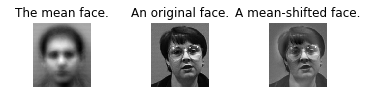

In [5]:
def show(image, m=200, n=180):
    """Plot the flattened grayscale 'image' of width 'w' and height 'h'.
    
    Parameters:
        image ((mn,) ndarray): A flattened image.
        m (int): The original number of rows in the image.
        n (int): The original number of columns in the image.
    """
    shaped = np.reshape(image, (m,n))   # reshape the given image
    plt.imshow(shaped, cmap="gray")     # show the image
    plt.axis("off")                     # turn off the axes
    
face = FacialRec()    # Initialize a FacialRec object 
# Plot mean face
plt.subplot(331)
show(face.mu)
plt.title("The mean face.")
# Plot original face
plt.subplot(332)
show(face.F[:,0])
plt.title("An original face.")
# Plot Mean-Shifted Face
plt.subplot(333)
show(face.Fbar[:,0])
plt.title("A mean-shifted face.")
plt.show()

### Show the svd simplified images projected onto different size spaces.

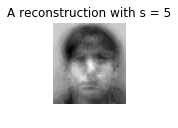

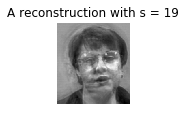

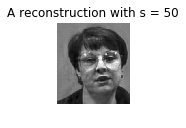

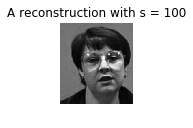

In [7]:
f = face.Fbar[:, 0]      # Define f to match formula
for index, s in enumerate([5, 19, 50, 100]):
    # Implement formula (7.3)
    reconstruction = face.U[:, :s] @ face.project(f, s) + face.mu
    # Plot using subplots
    plt.subplot(1, 4, index + 1)
    # Give an appropriate title
    plt.title(f"A reconstruction with s = {s}")
    # Use the plot function
    show(reconstruction)
    plt.show()

### Show the best matches for various random images.

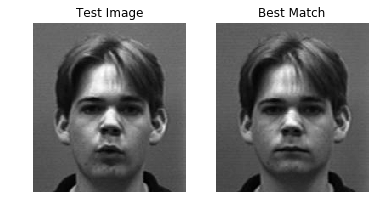

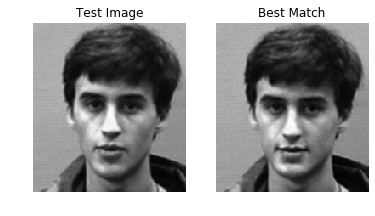

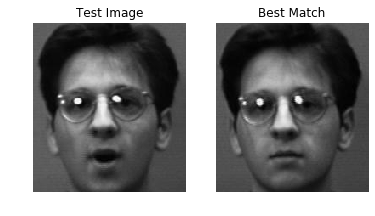

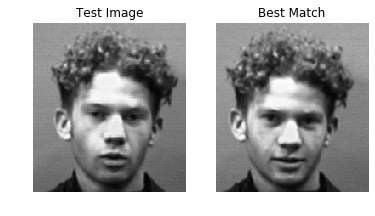

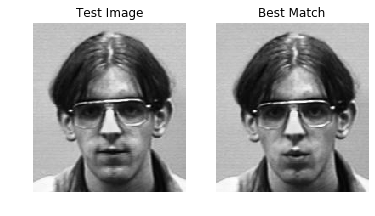

In [10]:
for test_image in sample_faces(5):
    # Find nearest likeness
    j = face.find_nearest(test_image, 38)
    # Plot the results!
    plt.subplot(121)
    show(test_image)
    plt.title("Test Image")
    plt.subplot(122)
    show(face.F[:,j])
    plt.title("Best Match")
    plt.show()